# Hardware Model 1 on QUT

### A Simple Introduction to Spiking Neural Networks with NeuronovaSim
First, we need to import common libraries and Neuronova-Sim (N-Wave)

### Loading the dataset

We use mini_QUT, an internal dataset composed of the first 100 recordings for each class.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Import necessary components from your library
from Neuronova_Sim.NeuronovaSim import NeuronovaSim

In [2]:
# We set our seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
class CochleaDataset(Dataset):
    """
    Dataset class for loading neural response data organized in class-specific folders.
    Data structure:
    root_folder/
        class1/
            file1.csv
            file2.csv
        class2/
            file3.csv
            file4.csv
    """

    def __init__(self, root_folder, split="train", val_split=0.2, random_state=42):
        assert split in [
            "train",
            "val",
            "test",
        ], f"Split {split} not recognized. Use 'train', 'val', or 'test'"
        self.files = []
        self.labels = []
        self.class_to_idx = {}
        self.split = split

        # Get all class folders
        class_folders = [
            d
            for d in os.listdir(root_folder)
            if os.path.isdir(os.path.join(root_folder, d))
        ]

        # Save classes number
        self.n_classes = len(class_folders)

        # Create class mapping
        self.class_to_idx = {
            cls_name: idx for idx, cls_name in enumerate(sorted(class_folders))
        }

        print(f"Found {self.n_classes} classes: {list(self.class_to_idx.keys())}")

        # Collect all files and labels
        all_files = []
        all_labels = []
        for class_name in class_folders:
            class_path = os.path.join(root_folder, class_name)
            class_files = [
                os.path.join(class_path, f)
                for f in os.listdir(class_path)
                if f.endswith(".csv") and not f.startswith(".")
            ]
            all_files.extend(class_files)
            all_labels.extend([self.class_to_idx[class_name]] * len(class_files))
            print(f"Class '{class_name}': {len(class_files)} samples")

        # Create a deterministic split
        generator = torch.Generator().manual_seed(random_state)
        indices = torch.randperm(len(all_files), generator=generator)

        # Calculate split sizes
        val_size = int(len(indices) * val_split)
        train_size = len(indices) - val_size

        # Select appropriate indices based on split
        if split == "train":
            split_indices = indices[:train_size]
        elif split == "val":
            split_indices = indices[train_size:]
        elif split == "test":
            split_indices = indices

        # Use the selected indices to populate the dataset
        self.files = [all_files[i] for i in split_indices]
        self.labels = [all_labels[i] for i in split_indices]

        print(f"Using '{split}' split with {len(self.files)} samples")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        label = self.labels[idx]
        label = torch.tensor(label)
        label_one_hot = torch.nn.functional.one_hot(label, num_classes=self.n_classes)

        # Load neural response data
        # Each row is a time bin, each column is a neuron
        data = np.loadtxt(file_path, delimiter=",", dtype=np.float32, encoding="latin1")

        # Reshape to (time_bins, n_neurons)
        # No need to add extra dimension since we already have multiple neurons
        data = data.reshape(data.shape[0], -1)  # Force 2D shape in case single neuron

        # Convert to tensor with shape (time_bins, n_neurons)
        data_tensor = torch.tensor(data, dtype=torch.float32)

        return data_tensor, label_one_hot, file_path


# Dataset disk position and batchsize
data_dir = "../data/4bit_frontend/mini_TRAIN_VAL"
batch_size = 32

# Create the datasets
train_dataset = CochleaDataset(data_dir, split="train")
val_dataset = CochleaDataset(data_dir, split="val")

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

Found 4 classes: ['CAFE-mini', 'CAR-mini', 'HOME-mini', 'STREET-mini']
Class 'CAFE-mini': 96 samples
Class 'HOME-mini': 96 samples
Class 'CAR-mini': 96 samples
Class 'STREET-mini': 96 samples
Using 'train' split with 308 samples
Found 4 classes: ['CAFE-mini', 'CAR-mini', 'HOME-mini', 'STREET-mini']
Class 'CAFE-mini': 96 samples
Class 'HOME-mini': 96 samples
Class 'CAR-mini': 96 samples
Class 'STREET-mini': 96 samples
Using 'val' split with 76 samples


### Let's define the network
We need to normalize the dataset since it is quantized to 4 bits
(So let's devide the input by 15)

In [5]:
# Define a simple model using NeuronovaSim
class SimpleSNN(torch.nn.Module):
    def __init__(
        self,
        input_size=16,
        hidden_size=24,
        output_size=4,
        norm_factor=15,  # We need to normalize the dataset with 4bit integer precision
        dt=1e-3,
        add_mismatch=False,
        bits_synapse=None,  # Set to a number to enable quantization
    ):
        super().__init__()

        self.norm_factor = torch.tensor(norm_factor)

        # Define network architecture - neurons per layer
        neurons_per_layer = [hidden_size, hidden_size, hidden_size, output_size]

        # Create the NeuronovaSim instance
        # Parameters: network type, model type, input size, neurons per layer
        self.sim = NeuronovaSim(
            chip_topology = ["FF", "FF"],
            chip_model = "HWModel_1",
            input_size=input_size,
            neuron_number_per_layer=neurons_per_layer,
            taus=62.7e-3,
            thresholds=0.222,
            dt=1e-3
        )

        print(
            f"Created NeuronovaSim with {input_size} inputs and {len(neurons_per_layer)} layers:"
        )
        print(f"  - Layer 1: {neurons_per_layer[0]} neurons")
        print(f"  - Layer 2: {neurons_per_layer[1]} neurons")
        print(f"  - Layer 3: {neurons_per_layer[2]} neurons")
        print(f"  - Output: {neurons_per_layer[3]} neurons")

    def forward(self, x):
        # x is expected to be (batch_size, time_steps, input_features)
        device = x.device

        # Normalize the input
        # This is used to normalize the first layer between 0 and 1
        # based on the maximum firing rate from the dataset
        x_normalized = x / self.norm_factor

        # Call the simulator, which returns:
        # (cur1, cur2, cur3, cur4, spk1, spk2, spk3, spk4, mem1, mem2, mem3, mem4)
        outs = self.sim.forward(x_normalized)

        # Unpack the simulator outputs
        (
            spk1,
            spk2,
            spk3,
            spk4,
            mem1,
            mem2,
            mem3,
            mem4,
            cur1,
            cur2,
            cur3,
            cur4,
        ) = outs

        # Rearrange the outputs from (batch, time, features) to (time, batch, features)
        #
        cur1 = cur1.permute(1, 0, 2)
        cur2 = cur2.permute(1, 0, 2)
        cur3 = cur3.permute(1, 0, 2)
        cur4 = cur4.permute(1, 0, 2)

        spk1 = spk1.permute(1, 0, 2)
        spk2 = spk2.permute(1, 0, 2)
        spk3 = spk3.permute(1, 0, 2)
        spk4 = spk4.permute(1, 0, 2)

        mem1 = mem1.permute(1, 0, 2)
        mem2 = mem2.permute(1, 0, 2)
        mem3 = mem3.permute(1, 0, 2)
        mem4 = mem4.permute(1, 0, 2)

        # Return all outputs for detailed analysis
        return (spk1, spk2, spk3, spk4, mem1, mem2, mem3, mem4, cur1, cur2, cur3, cur4)


# Parameters
input_size = 16
hidden_size = 24
output_size = 4
norm_factor = 15  # Used to normalize input between 0 and 1


# Create the SNN model
model = SimpleSNN(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    norm_factor=norm_factor,
    dt=1e-3,
    add_mismatch=False,
    bits_synapse=None,  # Set to a number to enable quantization
)


# weight_range = (0.6, 2)
# model.sim.get_layers()[0].init_weight(weight_range)
# model.sim.get_layers()[2].init_weight(weight_range)
# model.sim.get_layers()[4].init_weight(weight_range)
# model.sim.get_layers()[6].init_weight(weight_range)

# model.sim.get_layers()[0].fake_quant.set_w_range(w_min=1.3, w_max=2)
# model.sim.get_layers()[2].fake_quant.set_w_range(w_min=1.3, w_max=2)
# model.sim.get_layers()[4].fake_quant.set_w_range(w_min=1.3, w_max=2)
# model.sim.get_layers()[6].fake_quant.set_w_range(w_min=1.3, w_max=2)

# Print model information
print(
    f"\nModel created with input_size={input_size}, hidden_size={hidden_size}, output_size={output_size}"
)

Created NeuronovaSim with 16 inputs and 4 layers:
  - Layer 1: 24 neurons
  - Layer 2: 24 neurons
  - Layer 3: 24 neurons
  - Output: 4 neurons

Model created with input_size=16, hidden_size=24, output_size=4


### Define Loss Function

In [6]:
# Helper function to compute accuracy
def compute_loss_and_metrics(
    spk_rec,
    labels,
):
    ### Regularizer Params ###
    rate_offset = 0.25
    cross_reg_weight = 1000

    ### Torch Loss function
    loss_function = nn.CrossEntropyLoss()

    activity = spk_rec.sum(dim=1)  # -> (B, C)

    # extract class-indices
    _, targets = labels.max(-1)  # -> (B,)

    # cross-entropy on (B,C) vs (B,)
    main_loss = loss_function(activity, targets)

    # firing-rate regularization
    time_steps = spk_rec.size(1)  # ⟵ use time-axis
    avg_firing_rate = activity.mean() / time_steps
    rate_reg = (avg_firing_rate - rate_offset).pow(2).mean()

    loss = main_loss + cross_reg_weight * rate_reg

    # now compute accuracy on same summed output
    final_out = spk_rec.sum(dim=1)

    _, predicted = final_out.max(-1)  # -> (B,)
    _, targets = labels.max(-1)  # -> (B,)

    correct = predicted.eq(targets).sum().item()
    total = targets.numel()
    accuracy = correct / total if total > 0 else 0.0

    return loss, accuracy, predicted, targets

### Train and plot function

In [7]:
# Helper function to visualize SNN activity
def plot_snn_activity(spk1, spk2, spk3, spk4, mem1, mem2, mem3, mem4, sample_idx=0):
    """
    Plots the membrane potential and spikes for each layer.
    """
    fig, axs = plt.subplots(4, 2, figsize=(15, 10))
    fig.suptitle(f"SNN Activity for Sample {sample_idx}", fontsize=14)

    layer_names = ["Layer 1", "Layer 2", "Layer 3", "Output Layer"]
    mem_arrs = [mem1, mem2, mem3, mem4]
    spk_arrs = [spk1, spk2, spk3, spk4]

    for i in range(4):
        if mem_arrs[i] is not None:
            # Select one neuron from each layer for visualization
            axs[i, 0].plot(mem_arrs[i][sample_idx, :, :].cpu().detach().numpy())
            axs[i, 0].set_title(f"{layer_names[i]} - Membrane Potentials")
            axs[i, 0].set_xlabel("Time Step")
            axs[i, 0].set_ylabel("Vmem")

        if spk_arrs[i] is not None:
            # Plot spike raster for a few neurons
            spike_data = spk_arrs[i][sample_idx, :, :].cpu().detach().numpy()
            for n in range(min(10, spike_data.shape[1])):  # Plot up to 10 neurons
                spike_times = np.where(spike_data[:, n] > 0.5)[0]
                axs[i, 1].scatter(
                    spike_times, [n] * len(spike_times), marker="|", color="black", s=20
                )

            axs[i, 1].set_title(f"{layer_names[i]} - Spike Raster")
            axs[i, 1].set_xlabel("Time Step")
            axs[i, 1].set_ylabel("Neuron Index")
            axs[i, 1].set_ylim(-0.5, min(10, spike_data.shape[1]) - 0.5)

    plt.tight_layout()
    plt.show()


# Function to train the SNN for a few epochs
def train_snn(model, dataloader, num_epochs=5, loss_offset=0.5):
    """
    Training loop for the SNN using concepts from the original experiment code.
    """
    # Define optimizer (similar to the original code which used Adamax)
    optimizer = torch.optim.Adamax(model.parameters(), lr=0.01)

    # Training statistics tracking (similar to mean_fires in the original)
    layer_stats = {
        "Firing activity layer 1": 0,
        "Firing activity layer 2": 0,
        "Firing activity layer 3": 0,
        "Firing activity layer 4": 0,
        "Train Batches": 0,
    }

    # Training loop
    for epoch in range(num_epochs):
        # Reset epoch statistics
        total_loss = 0
        total_acc = 0
        num_batches = 0

        # Reset layer statistics
        for key in layer_stats:
            layer_stats[key] = 0

        for batch_idx, (inputs, labels, _) in enumerate(dataloader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Unpack outputs
            spk1, spk2, spk3, spk4, mem1, mem2, mem3, mem4, cur1, cur2, cur3, cur4 = (
                outputs
            )

            # Calculate accuracy and loss with the updated function
            loss, accuracy, predicted, targets = compute_loss_and_metrics(spk4, labels)

            # Backward pass and optimization
            loss.backward()

            # Add gradient clipping like in the original
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Track firing activities (similar to the original code)
            with torch.no_grad():
                layer_stats["Firing activity layer 1"] += spk1.mean().item()
                layer_stats["Firing activity layer 2"] += spk2.mean().item()
                layer_stats["Firing activity layer 3"] += spk3.mean().item()
                layer_stats["Firing activity layer 4"] += spk4.mean().item()
                layer_stats["Train Batches"] += 1

            total_loss += loss.item()
            total_acc += accuracy
            num_batches += 1

            if batch_idx == 0:

                if epoch % 25 == 0:
                    # Visualize network activity for the first sample in the batch
                    plot_snn_activity(spk1, spk2, spk3, spk4, mem1, mem2, mem3, mem4)

        # Epoch summary
        avg_loss = total_loss / num_batches
        avg_acc = total_acc / num_batches

        # Calculate average firing rates
        avg_firing_1 = (
            layer_stats["Firing activity layer 1"] / layer_stats["Train Batches"]
        )
        avg_firing_2 = (
            layer_stats["Firing activity layer 2"] / layer_stats["Train Batches"]
        )
        avg_firing_3 = (
            layer_stats["Firing activity layer 3"] / layer_stats["Train Batches"]
        )
        avg_firing_4 = (
            layer_stats["Firing activity layer 4"] / layer_stats["Train Batches"]
        )

        print(f"Epoch {epoch+1} completed:")
        print(f"  - Avg Loss: {avg_loss:.4f}")
        print(f"  - Avg Accuracy: {avg_acc:.4f}")
        print(
            f"  - Avg Firing Rates: L1={avg_firing_1:.4f}, L2={avg_firing_2:.4f}, L3={avg_firing_3:.4f}, L4={avg_firing_4:.4f}"
        )

        # Check if firing rates are too low (early stopping like in original)
        if avg_firing_4 <= 0.001:
            print(
                "Warning: Very low firing rate in output layer. Training may be unstable."
            )

    return model

### Training and validation 


Input shape: torch.Size([32, 1000, 16])
Label shape: torch.Size([32, 4])

Running initial forward pass...
Output spike shape (layer 4): torch.Size([32, 1000, 4])
Output membrane shape (layer 4): torch.Size([32, 1000, 4])
Initial accuracy: 0.3125


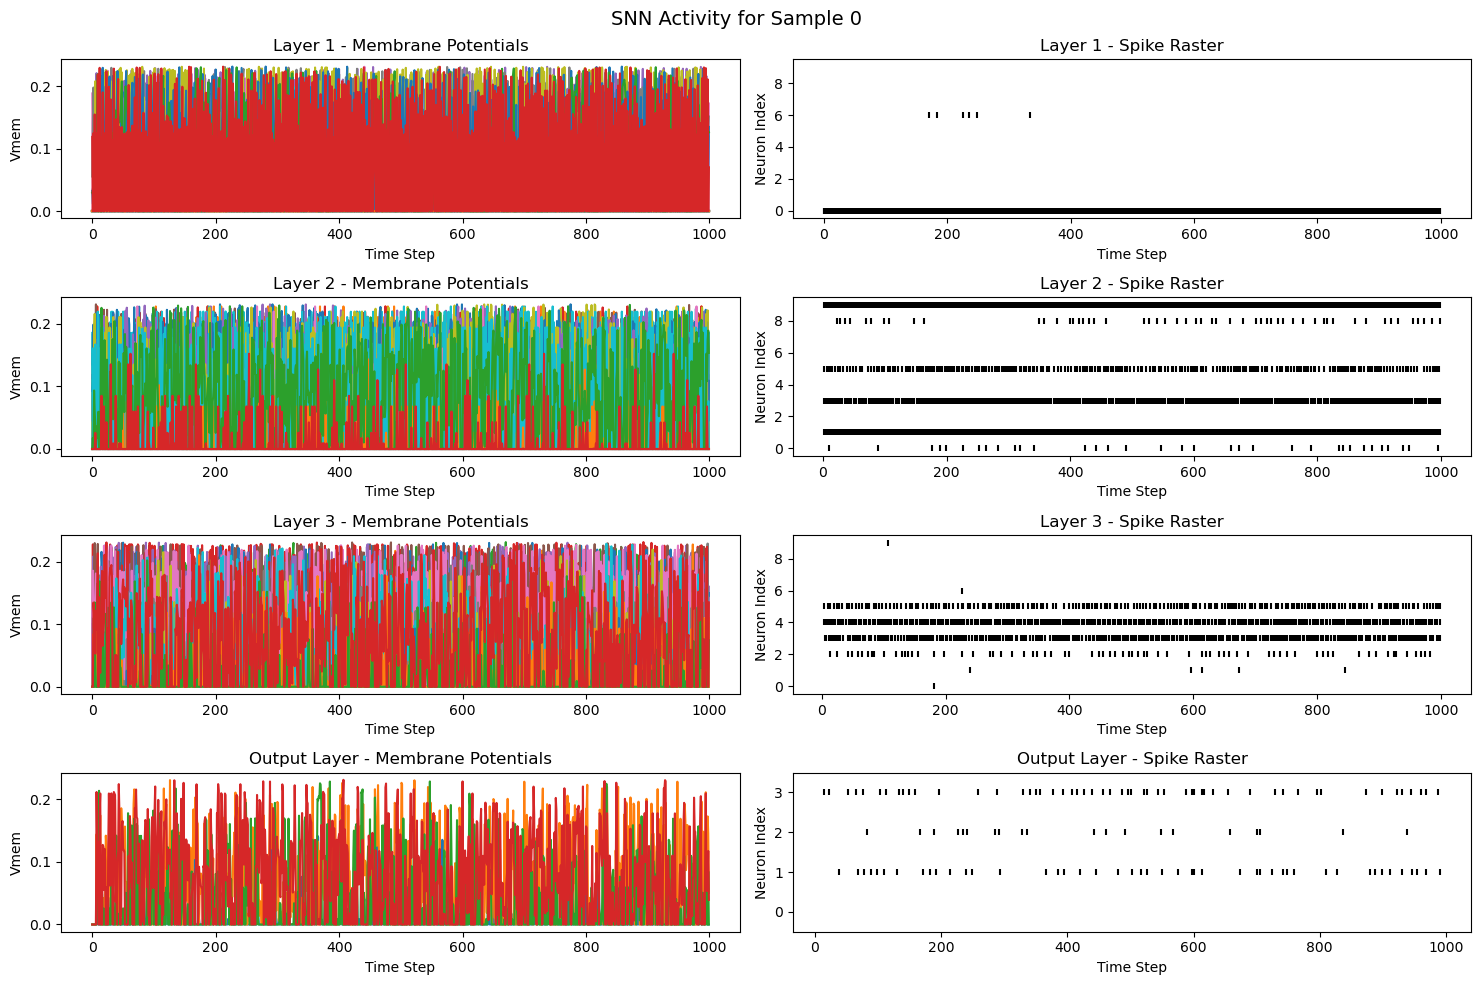


Training the SNN model...


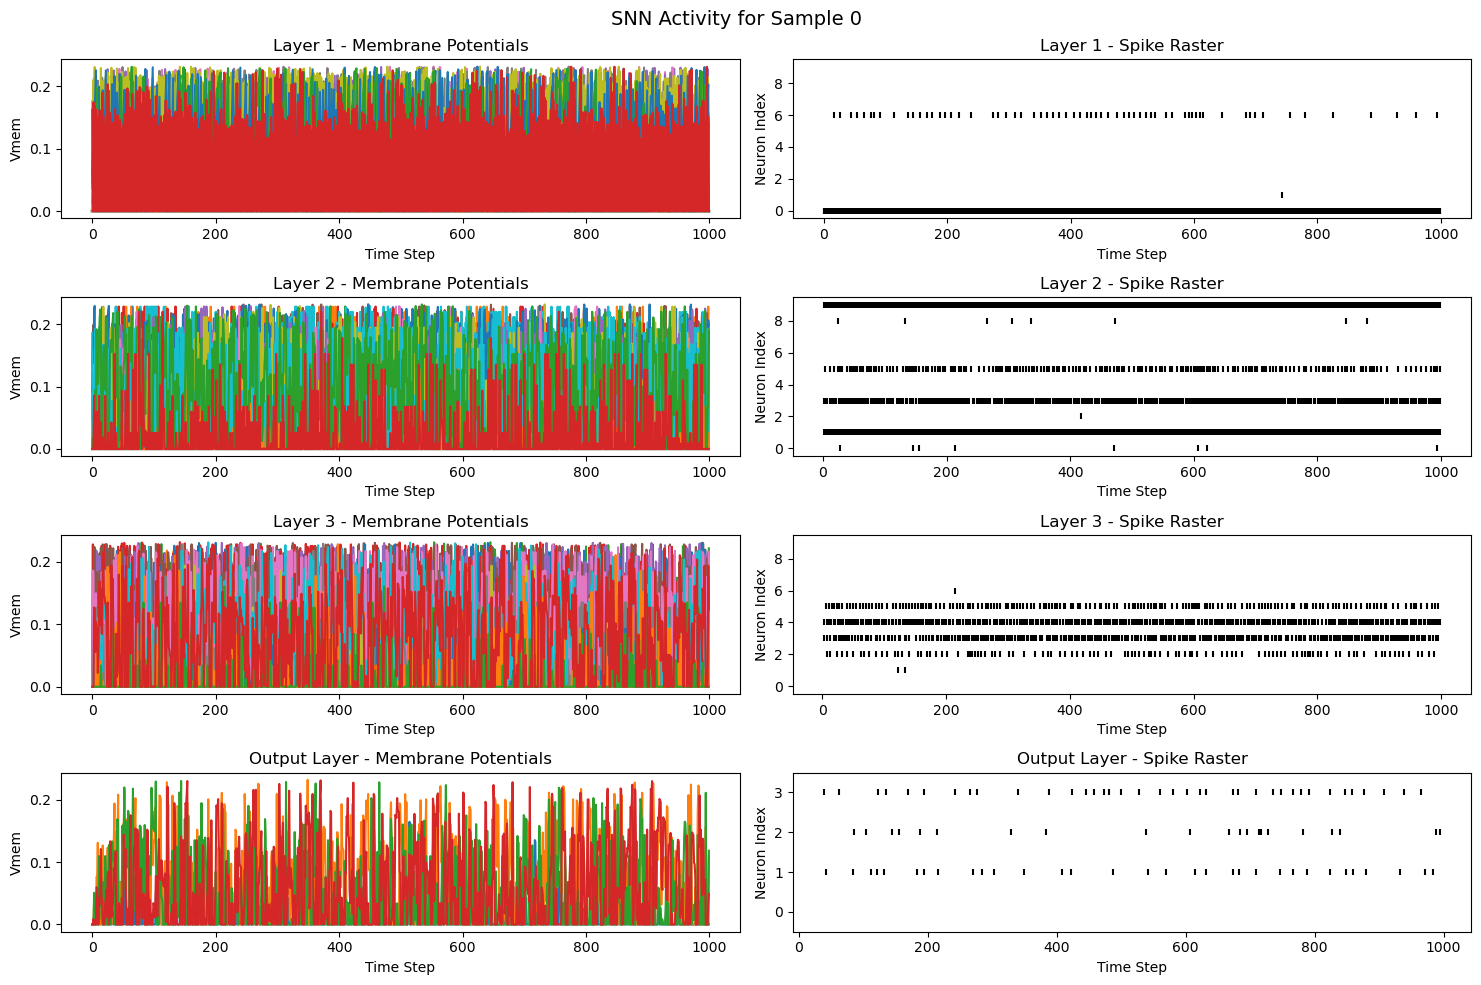

Epoch 1 completed:
  - Avg Loss: 76.3351
  - Avg Accuracy: 0.3725
  - Avg Firing Rates: L1=0.1650, L2=0.1259, L3=0.0845, L4=0.0208
Epoch 2 completed:
  - Avg Loss: 63.7293
  - Avg Accuracy: 0.3888
  - Avg Firing Rates: L1=0.1590, L2=0.1149, L3=0.0739, L4=0.0010
Epoch 3 completed:
  - Avg Loss: 63.5545
  - Avg Accuracy: 0.4056
  - Avg Firing Rates: L1=0.1586, L2=0.1113, L3=0.0699, L4=0.0004
Epoch 4 completed:
  - Avg Loss: 63.4209
  - Avg Accuracy: 0.4794
  - Avg Firing Rates: L1=0.1598, L2=0.1128, L3=0.0697, L4=0.0005
Epoch 5 completed:
  - Avg Loss: 62.9357
  - Avg Accuracy: 0.4894
  - Avg Firing Rates: L1=0.1615, L2=0.1180, L3=0.0733, L4=0.0014
Epoch 6 completed:
  - Avg Loss: 62.6121
  - Avg Accuracy: 0.3912
  - Avg Firing Rates: L1=0.1638, L2=0.1231, L3=0.0793, L4=0.0031
Epoch 7 completed:
  - Avg Loss: 61.9755
  - Avg Accuracy: 0.4169
  - Avg Firing Rates: L1=0.1606, L2=0.1184, L3=0.0763, L4=0.0053
Epoch 8 completed:
  - Avg Loss: 61.0972
  - Avg Accuracy: 0.3263
  - Avg Firing Ra

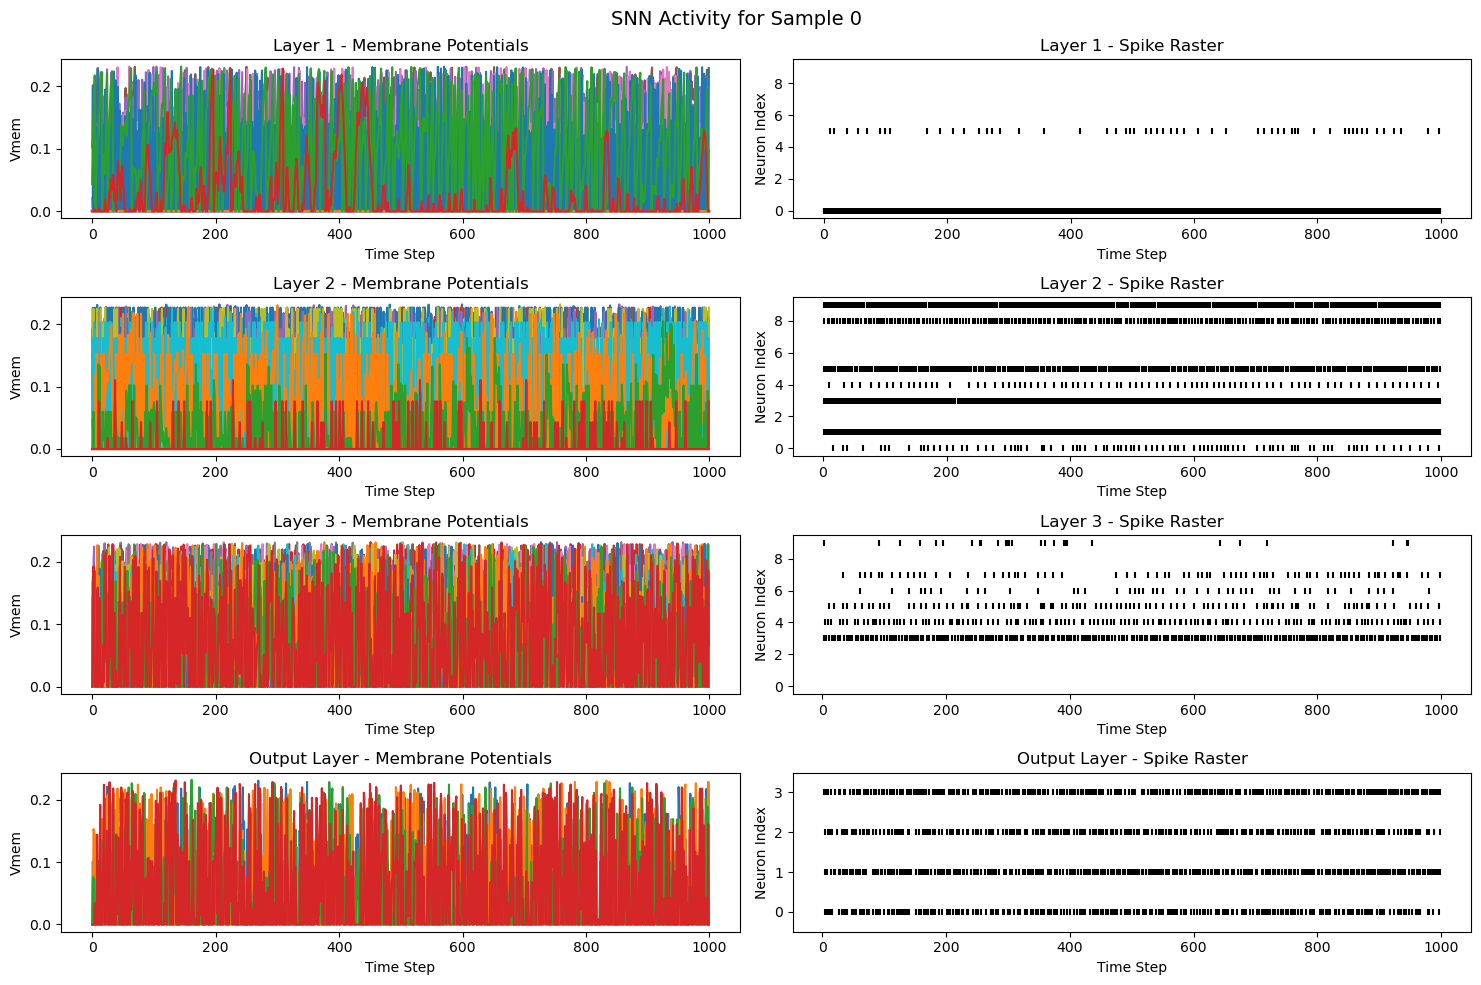

Epoch 26 completed:
  - Avg Loss: 2.3316
  - Avg Accuracy: 0.7244
  - Avg Firing Rates: L1=0.1449, L2=0.1397, L3=0.1310, L4=0.2508
Epoch 27 completed:
  - Avg Loss: 2.0084
  - Avg Accuracy: 0.7819
  - Avg Firing Rates: L1=0.1442, L2=0.1393, L3=0.1295, L4=0.2441
Epoch 28 completed:
  - Avg Loss: 2.1144
  - Avg Accuracy: 0.7338
  - Avg Firing Rates: L1=0.1419, L2=0.1364, L3=0.1264, L4=0.2345
Epoch 29 completed:
  - Avg Loss: 2.1603
  - Avg Accuracy: 0.7638
  - Avg Firing Rates: L1=0.1414, L2=0.1363, L3=0.1288, L4=0.2427
Epoch 30 completed:
  - Avg Loss: 3.2408
  - Avg Accuracy: 0.7013
  - Avg Firing Rates: L1=0.1390, L2=0.1327, L3=0.1247, L4=0.2408
Epoch 31 completed:
  - Avg Loss: 4.7748
  - Avg Accuracy: 0.7106
  - Avg Firing Rates: L1=0.1369, L2=0.1310, L3=0.1242, L4=0.2483
Epoch 32 completed:
  - Avg Loss: 5.1375
  - Avg Accuracy: 0.6394
  - Avg Firing Rates: L1=0.1371, L2=0.1320, L3=0.1252, L4=0.2551
Epoch 33 completed:
  - Avg Loss: 3.4347
  - Avg Accuracy: 0.6750
  - Avg Firing Ra

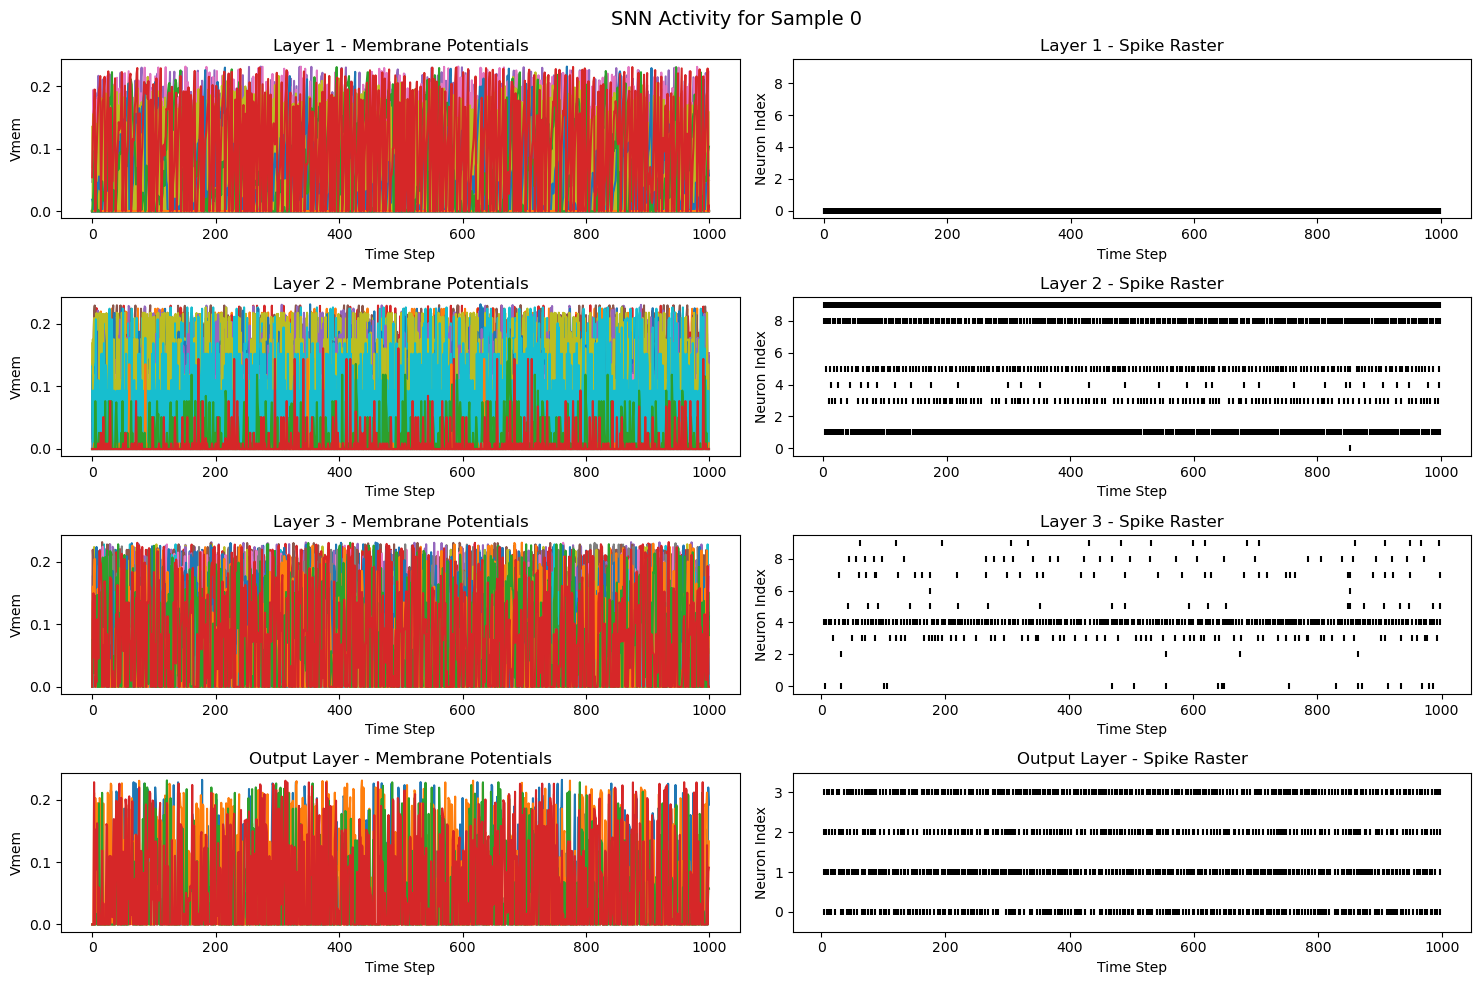

Epoch 51 completed:
  - Avg Loss: 1.2225
  - Avg Accuracy: 0.8838
  - Avg Firing Rates: L1=0.1225, L2=0.1050, L3=0.0937, L4=0.2476
Epoch 52 completed:
  - Avg Loss: 1.2533
  - Avg Accuracy: 0.9200
  - Avg Firing Rates: L1=0.1222, L2=0.1050, L3=0.0952, L4=0.2509
Epoch 53 completed:
  - Avg Loss: 0.9245
  - Avg Accuracy: 0.9100
  - Avg Firing Rates: L1=0.1236, L2=0.1058, L3=0.0948, L4=0.2483
Epoch 54 completed:
  - Avg Loss: 1.5219
  - Avg Accuracy: 0.8575
  - Avg Firing Rates: L1=0.1254, L2=0.1064, L3=0.0944, L4=0.2448
Epoch 55 completed:
  - Avg Loss: 2.3782
  - Avg Accuracy: 0.8363
  - Avg Firing Rates: L1=0.1262, L2=0.1059, L3=0.0919, L4=0.2430
Epoch 56 completed:
  - Avg Loss: 3.3283
  - Avg Accuracy: 0.8144
  - Avg Firing Rates: L1=0.1271, L2=0.1053, L3=0.0911, L4=0.2447
Epoch 57 completed:
  - Avg Loss: 1.2083
  - Avg Accuracy: 0.8806
  - Avg Firing Rates: L1=0.1268, L2=0.1045, L3=0.0909, L4=0.2475
Epoch 58 completed:
  - Avg Loss: 0.6997
  - Avg Accuracy: 0.9350
  - Avg Firing Ra

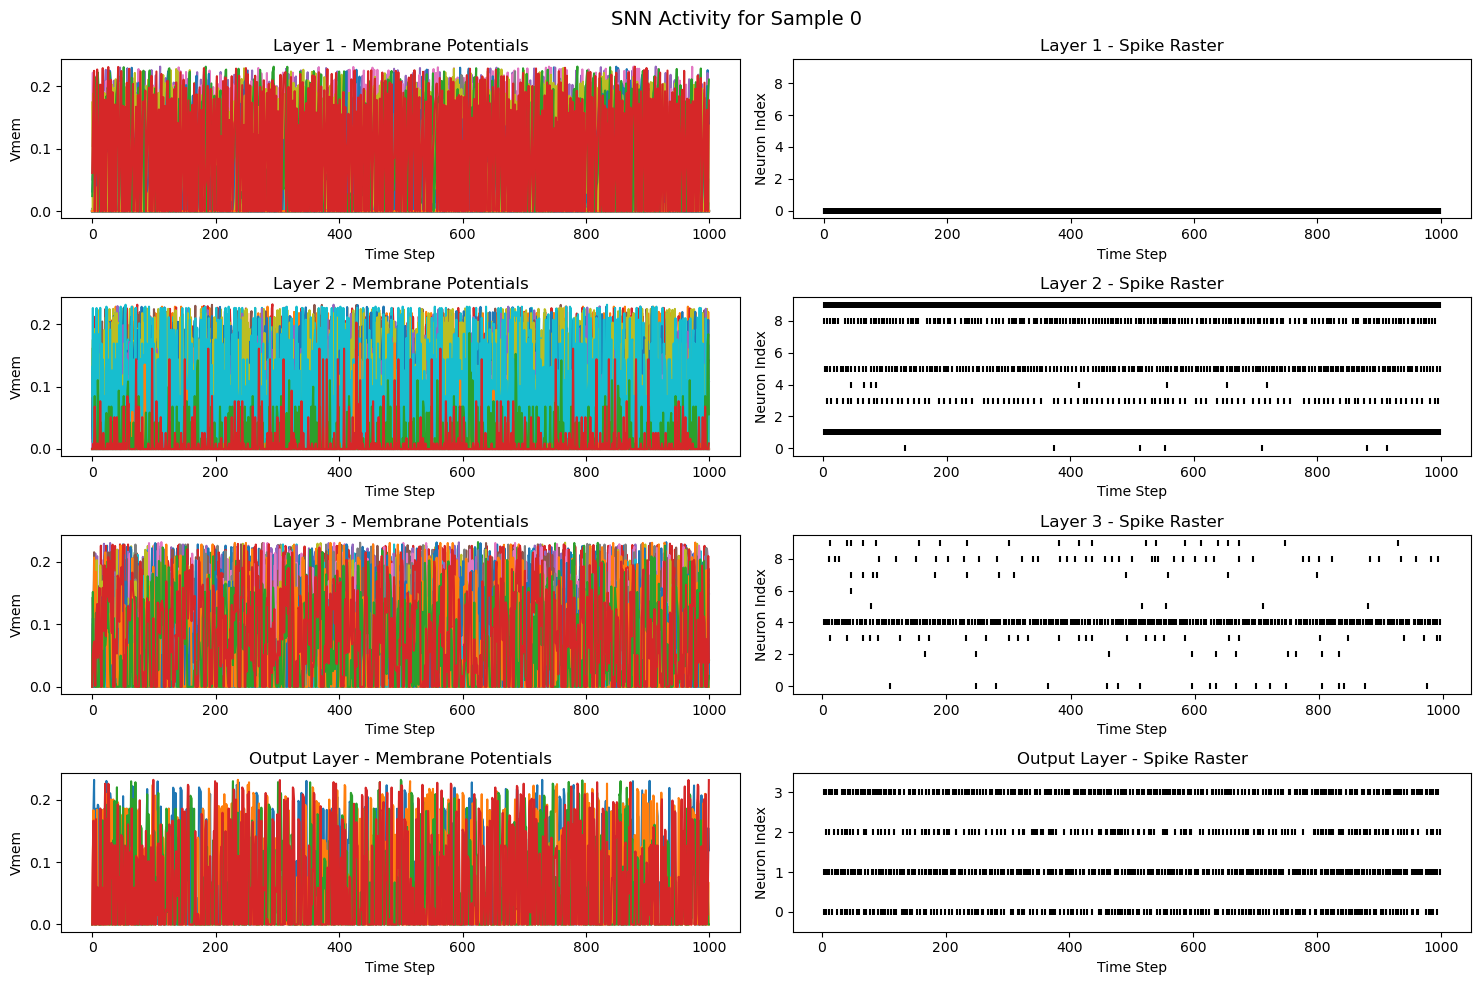

Epoch 76 completed:
  - Avg Loss: 0.6446
  - Avg Accuracy: 0.9313
  - Avg Firing Rates: L1=0.1318, L2=0.1045, L3=0.0861, L4=0.2516
Epoch 77 completed:
  - Avg Loss: 1.2791
  - Avg Accuracy: 0.9075
  - Avg Firing Rates: L1=0.1321, L2=0.1041, L3=0.0845, L4=0.2487
Epoch 78 completed:
  - Avg Loss: 0.4053
  - Avg Accuracy: 0.9469
  - Avg Firing Rates: L1=0.1308, L2=0.1031, L3=0.0849, L4=0.2492
Epoch 79 completed:
  - Avg Loss: 1.1221
  - Avg Accuracy: 0.9131
  - Avg Firing Rates: L1=0.1322, L2=0.1019, L3=0.0826, L4=0.2446
Epoch 80 completed:
  - Avg Loss: 1.8048
  - Avg Accuracy: 0.8681
  - Avg Firing Rates: L1=0.1288, L2=0.1031, L3=0.0872, L4=0.2586
Epoch 81 completed:
  - Avg Loss: 1.5463
  - Avg Accuracy: 0.8650
  - Avg Firing Rates: L1=0.1274, L2=0.1017, L3=0.0854, L4=0.2491
Epoch 82 completed:
  - Avg Loss: 1.1844
  - Avg Accuracy: 0.9225
  - Avg Firing Rates: L1=0.1279, L2=0.1014, L3=0.0804, L4=0.2445
Epoch 83 completed:
  - Avg Loss: 1.1943
  - Avg Accuracy: 0.9206
  - Avg Firing Ra

In [8]:
# Grab one batch to visualize initial network activity

inputs, labels, _ = next(iter(train_loader))

print(f"\nInput shape: {inputs.shape}")
print(f"Label shape: {labels.shape}")

# Do a forward pass
with torch.no_grad():
    print("\nRunning initial forward pass...")
    outputs = model(inputs)
    spk1, spk2, spk3, spk4, mem1, mem2, mem3, mem4, cur1, cur2, cur3, cur4 = outputs

    # Print output shapes
    print(f"Output spike shape (layer 4): {spk4.shape}")
    print(f"Output membrane shape (layer 4): {mem4.shape}")

    # Calculate initial accuracy
    loss, accuracy, predicted, targets = compute_loss_and_metrics(spk4, labels)
    print(f"Initial accuracy: {accuracy:.4f}")

    # Visualize network activity
    plot_snn_activity(spk1, spk2, spk3, spk4, mem1, mem2, mem3, mem4)

# Train the model
print("\nTraining the SNN model...")
trained_model = train_snn(model, train_loader, num_epochs=100)

print("\nTraining completed!")

# Test the trained model on validation set
print("\nEvaluating the trained model on validation set...")

with torch.no_grad():
    total_acc = 0
    num_batches = 0

    for inputs, labels, _ in val_loader:
        outputs = trained_model(inputs)
        spk4 = outputs[3]  # Output layer spikes

        loss, accuracy, predicted, targets = compute_loss_and_metrics(spk4, labels)
        total_acc += accuracy
        num_batches += 1

    avg_acc = total_acc / num_batches
    print(f"Validation accuracy: {avg_acc:.4f}")


print("\nTutorial completed!")